In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import io
import cv2
import os
import random

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

main_directory = 'dataset/'
subfolders = ['paper','rock','scissors']

In [33]:
dataset=[]
label=0
for subfolder in subfolders:
    folder = os.path.join(main_directory,subfolder)
    for image in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,image),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (75, 50))
        img = img.flatten()
        img = img/255.0
        dataset.append((img,label))
    label+=1
random.shuffle(dataset)
X, y =zip(*dataset)

X = np.array(X)
y = np.array(y)

In [44]:
print(X.shape)

(2188, 3750)


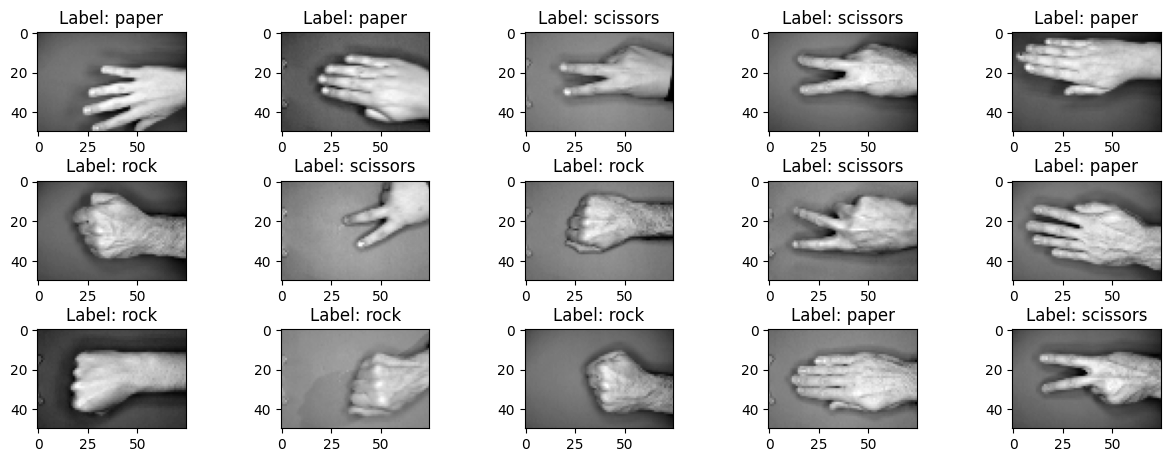

In [43]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5,n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i].reshape(50,75), cmap='gray')
    plt.title(f'Label: {subfolders[y[i]]}')

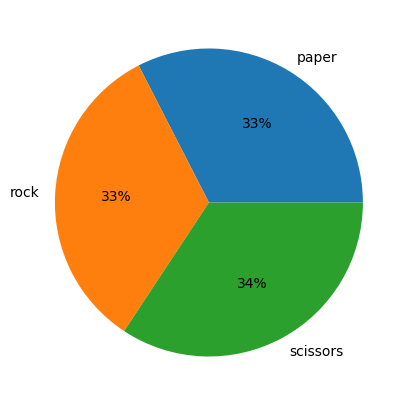

In [51]:
plt.figure(figsize=(7, 5))
unique, counts = np.unique(y,return_counts=True)

pie = plt.pie(counts,labels = subfolders, autopct='%1.0f%%')
plt.show()

TODO: 
- Pitati profesora za ImageDataGenerator
- Pitati za loss funkciju sta misli